<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [2]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Mounted at /content/drive


In [ ]:
!pip install dask[dataframe]

In [69]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

# Load data and Best LightGBM Models

Sets of features (data columns)

In [70]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os','month', 'session_length_in_minutes',
       'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session'] #, 'intended_balcon_amount']
SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper
PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
        'device_distinct_emails']

################################## SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled','month_scaled', 'session_length_in_minutes_scaled',
              'velocity_6h_scaled', 'velocity_24h_scaled', 'velocity_4w_scaled', 'email_is_free_scaled', 'proposed_credit_limit_scaled', 'keep_alive_session_scaled'] #, 'intended_balcon_amount_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = [['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'device_distinct_emails_scaled']]

'''Removed features:
device_fraud_count
device_fraud_count_scaled
intended_balcon_amount
intended_balcon_amount_scaled
'''

'Removed features:\ndevice_fraud_count\ndevice_fraud_count_scaled\nintended_balcon_amount\nintended_balcon_amount_scaled\n'

load data from parquet files

In [71]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best models from BAF_Reproduce notebook

In [72]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

# Explore data

In [73]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [74]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)

In [75]:
dfs = [base, variant1, variant2, variant3, variant4, variant5]

df = base
new_df = df.copy()
# Get the number of unique values in each column of the DataFrame
df.nunique()

,0
fraud_bool,2
income,9
name_email_similarity,998861
prev_address_months_count,374
current_address_months_count,423
customer_age,9
days_since_request,989330
intended_balcon_amount,994971
payment_type,5
zip_count_4w,6306


In [76]:
#remove features --> check for missing values first
features_to_remove = ['device_fraud_count', 'intended_balcon_amount']


for df_name, df in dataframes.items():
  for column in features_to_remove:
    if column in df.columns:
     df.drop(column, axis=1, inplace=True)


In [77]:
#variant1.iloc[500]
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,x1,x2
0,0,0.1,0.244166,214,3,50,20.662310,AA,1922,9333.076951,5633.318710,5950.091624,11,2,CA,131,1,BC,0,1,10,0,200.0,0,INTERNET,8.513914,linux,1,1,0,-0.600198,-0.296015
1,0,0.8,0.035690,-1,242,50,6.134627,AA,4614,8360.855068,4825.632888,6711.142697,2,7,CA,43,0,BE,1,0,28,0,200.0,0,INTERNET,4.399087,windows,1,1,0,-1.406937,2.136468
2,0,0.9,0.030506,-1,95,50,0.001012,AA,1231,1345.896623,4970.691033,4941.150902,33,2,CC,258,0,BA,1,1,30,0,1000.0,0,INTERNET,6.989680,linux,0,1,0,-0.688785,0.686640
3,0,0.9,0.840711,-1,105,60,0.012292,AA,1874,6299.614264,6564.003817,6300.931977,41,4,CA,126,0,BC,1,1,4,1,1500.0,0,INTERNET,50.544274,linux,0,1,0,-0.865885,-2.078178
4,0,0.7,0.275118,-1,374,60,1.081235,AD,5070,9170.708398,7021.570083,6655.351345,10,2,CB,88,1,BC,1,0,30,0,200.0,0,INTERNET,4.847442,linux,1,1,0,-0.339504,-2.032053


In [78]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011030,0.104443,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.578958,0.288226,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.487527,0.291367,7.898994e-07,0.214529,0.485893,0.754531,1.000000
prev_address_months_count,1000000.0,14.744036,43.134138,-1.000000e+00,-1.000000,-1.000000,-1.000000,384.000000
current_address_months_count,1000000.0,99.187295,94.070293,-1.000000e+00,27.000000,64.000000,154.000000,426.000000
customer_age,1000000.0,41.349480,13.751920,1.000000e+01,30.000000,50.000000,50.000000,90.000000
days_since_request,1000000.0,0.916476,5.068976,1.414624e-07,0.007451,0.015673,0.026988,77.845545
zip_count_4w,1000000.0,1517.471615,965.945989,1.000000e+00,885.000000,1208.000000,1846.000000,6830.000000
velocity_6h,1000000.0,5490.939853,2940.124992,-1.436497e+02,3332.981127,5190.722819,7371.559084,16802.052304
velocity_24h,1000000.0,4661.530105,1450.442084,1.297721e+03,3505.061781,4641.570668,5593.342744,9585.100782


In [79]:
df.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,399073
employment_status,1000000,7,CA,685037
housing_status,1000000,7,BC,336096
source,1000000,2,INTERNET,992330
device_os,1000000,5,linux,337150


In [80]:
df_frauds = pd.DataFrame(df['fraud_bool'].value_counts())
print(df_frauds)

             count
fraud_bool        
0           988970
1            11030


missing values

In [81]:
missing_vals = pd.DataFrame()
missing_features = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

#replace -1 values with NaN, calculate percentage of missing values

for feature in missing_features:
  df.loc[base[feature] < 0, feature] = np.nan
  missing_vals_col = df.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x)* 100, 2))
  missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
0                               71.30                          0.43   
1                               70.47                          0.37   

            bank_months_count  session_length_in_minutes  \
fraud_bool                                                 
0                       25.36                       0.20   
1                       25.62                       0.24   

            device_distinct_emails_8w  
fraud_bool                             
0                                0.04  
1                                0.02  


In [61]:
(df['current_address_months_count']).value_counts()

,count
current_address_months_count,
6.0,16376
7.0,16270
8.0,16089
5.0,15896
9.0,15688
...,...
419.0,1
417.0,1
409.0,1


numeric features

In [82]:
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]
print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'x1', 'x2']


categorical features

In [83]:
categorical_features = [x for x in df.columns if df[x].dtypes == "O"]

print(categorical_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [66]:
#df.nunique()

In [84]:
df.describe(include=["object", "bool"]).transpose()


,count,unique,top,freq
payment_type,1000000,5,AB,399073
employment_status,1000000,7,CA,685037
housing_status,1000000,7,BC,336096
source,1000000,2,INTERNET,992330
device_os,1000000,5,linux,337150


In [85]:
#device fraud count was binary but 0 counts for class 1 so this feature is removed
'''df['device_fraud_count'].value_counts()
count_device = (df['device_fraud_count'] ==1).sum()
print(count_device)'''

"df['device_fraud_count'].value_counts()\ncount_device = (df['device_fraud_count'] ==1).sum()\nprint(count_device)"

In [86]:
#base['customer_age'].value_counts() #same as variant3

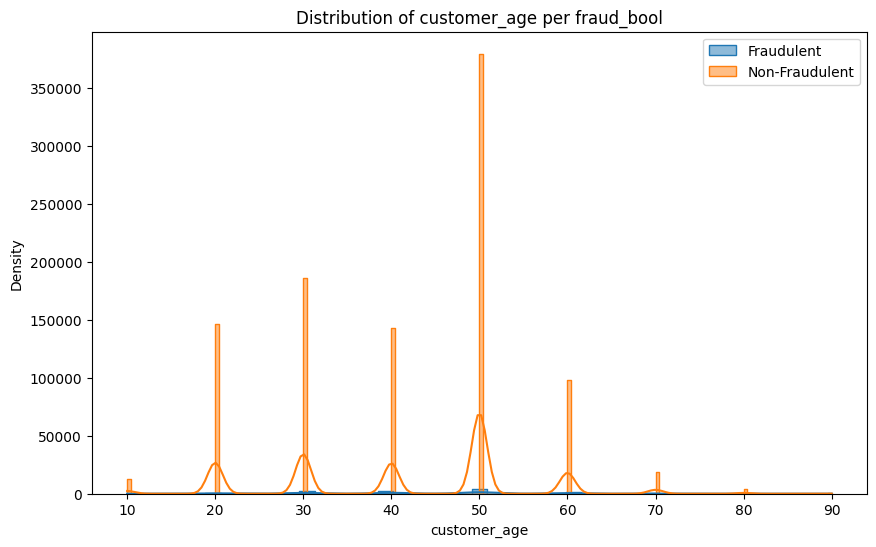

In [87]:
fraud_age = variant3.loc[variant3['fraud_bool'] == 1, 'customer_age']
nonfraud_age = variant3.loc[variant3['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show() #do this plot again after upsampling

In [88]:
variant3['customer_age'].value_counts()
variant3['income'].value_counts()
variant3['employment_status'].value_counts()

,count
employment_status,
CA,684981
CB,135133
CC,89089
CF,44943
CD,26648
CE,18719
CG,487


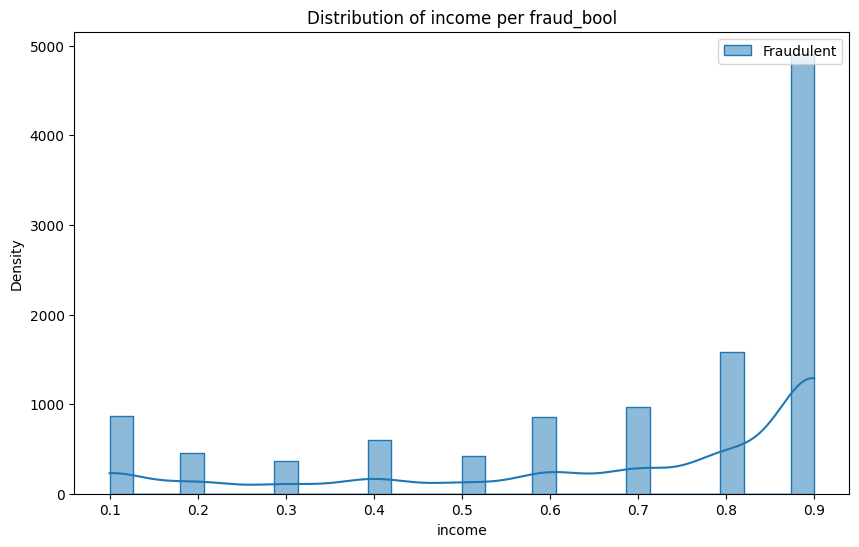

In [89]:
fraud_income = variant3.loc[variant3['fraud_bool'] == 1, 'income']
nonfraud_income = variant3.loc[variant3['fraud_bool'] == 0,'income']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_income, kde=True, label='Fraudulent', element='step')
sns.histplot()

plt.title('Distribution of income per fraud_bool')
plt.xlabel('income')
plt.ylabel('Density')
plt.legend()
plt.show()

# Pre-process

In [68]:
X = df.drop(columns=["fraud_bool"], axis =1)
Y = df["fraud_bool"]

Upsample to deal with imbalanced dataset

In [93]:
df_frauds = pd.DataFrame(df['fraud_bool'].value_counts())
print(df_frauds)

             count
fraud_bool        
0           988970
1            11030


In [94]:
df_majority = df[df["fraud_bool"] == 0]
df_minority = df[df["fraud_bool"] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples = int(0.1 * len(df_majority) / 0.9), #proportional to reflect the real-world frequency of fraud-cases
                                 #n_samples=len(df_majority), #equal class distribution
                                 random_state=42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print(df_upsampled.fraud_bool.value_counts())

fraud_bool
0    988970
1    109885
Name: count, dtype: int64


# Get the Errors

In [ ]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [ ]:
def get_errors (model, data, test_dfs):
    """
    Evaluate trained model on test data and compute metrics and errors.
    - model: Trained model (Best LightGBM model)
    - X_test: Feature matrix for the test data
    - Y_test: True labels for the test data

    Returns:
    - metrics: Dictionary containing calculated metrics (accuracy, precision, recall, f1, ROC AUC)
    - predictions: DataFrame containing the true and predicted classes along with errors
    """

    #get train and test data
    X_train = train_dfs[data].drop(columns=["fraud_bool"])
    Y_train = train_dfs[data]["fraud_bool"]
    X_test = test_dfs[data].drop(columns=["fraud_bool"])
    Y_test = test_dfs[data]["fraud_bool"]

    #predict
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

    # Convert predictions and true labels to integers if they are not already
    Y_pred = Y_pred.astype(int)  # Ensure predictions are integers (0 or 1)
    Y_test = Y_test.astype(int)  # Ensure true labels are integers (0 or 1)

   #get evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    #Print the evaluation metrics & confusion matrix
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create predictions DataFrame
    predictions = pd.DataFrame({
        'predicted_class': Y_pred,
        'true_class': Y_test,
        'errors': abs(Y_pred - Y_test)
    }, index=X_test.index)

    # Merge predictions with the original test data
    test_dfs[data] = pd.merge(test_dfs[data], predictions, left_index=True, right_index=True, how='outer')


    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
    }, predictions

In [ ]:
test_dfs['Base']

Add the metrics and errors to all variants

In [ ]:
base_metrics, base_error = get_errors(modelb, 'Base', test_dfs)
v1_metrics, v1_error = get_errors(modelv1, 'Variant I', test_dfs)
v2_metrics, v2_error = get_errors(modelv2, 'Variant II', test_dfs)
v3_metrics, v3_error = get_errors(modelv3, 'Variant III', test_dfs)
v4_metrics, v4_error = get_errors(modelv4, 'Variant IV', test_dfs)
v5_metrics, v5_error = get_errors(modelv5, 'Variant V', test_dfs)


#print(test_dfs['Base'].head())  # Includes original columns + true_class, predicted_class, errors
#print(test_dfs['Variant I'].head())  # Includes the same for 'Variant I'

In [ ]:
# Rename updated datasets to new variables
Base_error = test_dfs['Base']
V1_error = test_dfs['Variant I']
V2_error = test_dfs['Variant II']
V3_error = test_dfs['Variant III']
V4_error = test_dfs['Variant IV']
V5_error = test_dfs['Variant V']

# Get the error labels

In [ ]:
def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
Base_error = add_error_labels(Base_error)
V1_error = add_error_labels(V1_error)
V2_error = add_error_labels(V2_error)
V3_error = add_error_labels(V3_error)
V4_error = add_error_labels(V4_error)
V5_error = add_error_labels(V5_error)

In [ ]:
Base_error.head()
#Base_error.iloc[500]

In [ ]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [ ]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [ ]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)